In [1]:
# packages we have used
import numpy as np
from pyDOE2 import lhs
from scipy import stats
import matplotlib.pyplot as plt

# new packages
import subprocess  # calls external programmes via Python
from eppy.modeleditor import IDF  # interfaces idf files
from pathlib import Path  # handles paths in a cross-platform fashion
import csv  # reads and writes csv files

In [274]:
import csv
import random
import subprocess
import numpy as np
from pyDOE2 import lhs
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
from eppy.modeleditor import IDF

In [275]:
# Uncertainty analysis
ep_dir = Path("C:\EnergyPlusV9-4-0")

# specify the data directory that contains
# the model file, the weather file, and this notebook
tutorial_dir = Path(".").parent.resolve()

### 1. sampling

In [276]:
# define the sample size
# and generate latin hypercube samples
n_sample = 200
lhd = lhs(4, samples=n_sample)

In [277]:
# convert the latin hypercube samples
# to real samples for each input parameter
S_equip_gain = stats.norm(loc=200, scale=2).ppf(lhd[:, 3])
S_equip_rad_frac = stats.weibull_min(c=2.1, loc=0.5, scale=0.15).ppf(lhd[:, 1])
S_equip_sche = stats.triang(loc=0.1, scale=0.9, c=0.9).ppf(lhd[:, 2])
#S_win_height = stats.norm(loc=2, scale=0.1).ppf(lhd[:, 3])
S_ground_t = stats.norm(loc=10, scale=2).ppf(lhd[:, 3])
Terrain = ['Country','Suburbs','City','Ocean','Urban']
model = ['Case_600_a1.idf','Case_600_a3.idf']
#weather = ['BESTEST.epw']
weather = ['USA_CO_Denver.Intl.AP.725650_TMY3.epw','USA_CO_Denver.Intl.AP.725650_TMYx.2004-2018.epw','USA_CO_Denver.Intl.AP.725650_TMYx.2007-2021.epw','USA_CO_Denver.Intl.AP.725650_TMYx.epw','USA_CO_Denver.Intl.AP.725650_US.Normals.1991-2020.epw','USA_CO_Denver.Intl.AP.725650_US.Normals.2006-2020.epw','USA_CO_Denver-Centennial.AP.724666_TMYx.2004-2018.epw','USA_CO_Denver-Centennial.AP.724666_TMYx.2007-2021.epw','USA_CO_Denver-Centennial.AP.724666_TMYx.epw','USA_CO_Denver-Centennial.AP.724666_US.Normals.1991-2020.epw','USA_CO_Denver-Centennial.AP.724666_US.Normals.2006-2020.epw','USA_CO_Denver-Lowry.AFB.724691_TMYx.epw','USA_CO_Denver-Stapleton.AF.724690_TMYx.epw','USA_CO_Denver-Stapleton.Intl.AP.724690_TMY.epw','BESTEST.epw']
print(random.choice(model) )

Case_600_a3.idf


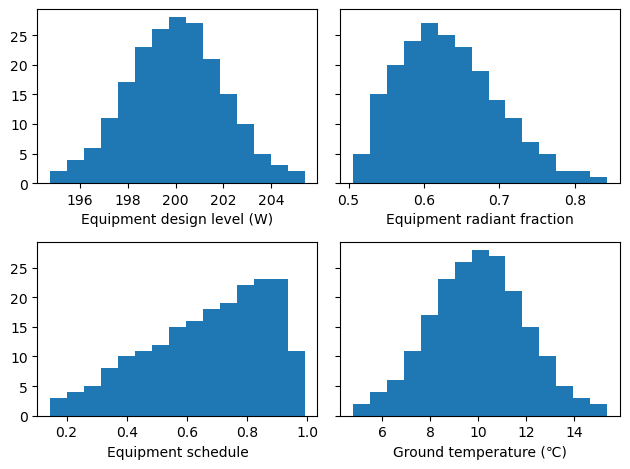

In [278]:
# plot the sample histograms
# to check their shape and value range
fig, axes = plt.subplots(2, 2, sharey=True)
axes[0, 0].hist(S_equip_gain, bins="sqrt")
axes[0, 0].set_xlabel("Equipment design level (W)")
axes[0, 1].hist(S_equip_rad_frac, bins="sqrt")
axes[0, 1].set_xlabel("Equipment radiant fraction")
axes[1, 0].hist(S_equip_sche, bins="sqrt")
axes[1, 0].set_xlabel("Equipment schedule")
axes[1, 1].hist(S_ground_t, bins="sqrt")
axes[1, 1].set_xlabel("Ground temperature (℃)")
fig.tight_layout()

# save the plot
fig.savefig("ua_input_parameters.png", dpi=500)

### 2. evaluation

In [279]:
# specify the idd file
idd_file = ep_dir / "Energy+.idd"
IDF.setiddname(idd_file)

# load the model
ua_idf = IDF(tutorial_dir / random.choice(model))

In [280]:
# create a subfolder to store simulation data
ua_dir = tutorial_dir / "ua"
ua_dir.mkdir()

In [282]:
# create the idf file for each job
for idx, (equip_gain, equip_rad_frac, equip_sche, ground_t) in enumerate(
    zip(S_equip_gain, S_equip_rad_frac, S_equip_sche, S_ground_t)
):
    # modify the equipment design level
    equipg_obj = ua_idf.idfobjects["ElectricEquipment"][0]
    equipg_obj.Design_Level = equip_gain

    # modify the radiant fraction of the equipment
    equip_obj = ua_idf.idfobjects["ElectricEquipment"][0]
    equip_obj.Fraction_Radiant = equip_rad_frac

    # modify the equipment schedule
    equipsche_obj = ua_idf.idfobjects["Schedule:Compact"][0]
    equipsche_obj.Field_6 = equip_sche
    
    # modify ground T
    ground_t_obj = ua_idf.idfobjects["Site:GroundTemperature:BuildingSurface"][0]
    ground_t_obj.January_Ground_Temperature = ground_t   
    ground_t_obj.February_Ground_Temperature = ground_t    
    ground_t_obj.March_Ground_Temperature = ground_t    
    ground_t_obj.April_Ground_Temperature = ground_t    
    ground_t_obj.May_Ground_Temperature = ground_t    
    ground_t_obj.June_Ground_Temperature = ground_t    
    ground_t_obj.July_Ground_Temperature = ground_t    
    ground_t_obj.August_Ground_Temperature = ground_t 
    ground_t_obj.September_Ground_Temperature = ground_t 
    ground_t_obj.October_Ground_Temperature = ground_t 
    ground_t_obj.November_Ground_Temperature = ground_t  
    ground_t_obj.December_Ground_Temperature = ground_t 
    
    #modify terrain
    terrain_obj = ua_idf.idfobjects["Building"][0]
    terrain_obj.Terrain = random.choice(Terrain) 
    
    # create the job folder
    job_dir = ua_dir / f"job_{idx:03}"
    job_dir.mkdir()

    # specify and save the job idf file
    job_idf_file = job_dir / "in.idf"
    ua_idf.saveas(job_idf_file)

In [284]:
# specify the energyplus executable
# and the weather file
ep_exe = ep_dir / "energyplus"


# simulate each job
for idx in range(n_sample):
    # specify the job idf file
    job_dir = ua_dir / f"job_{idx:03}"
    job_idf_file = job_dir / "in.idf"
    epw_file = tutorial_dir / random.choice(weather)

    # run ep
    commands = [ep_exe, "-x", "-r", "-w", epw_file, job_idf_file]
    subprocess.run(commands, cwd=job_dir, capture_output=True)

    # notify completion for every 10 jobs
    if idx % 10 == 9:
        print(f"job_{idx:03} finished.")

job_009 finished.
job_019 finished.
job_029 finished.
job_039 finished.
job_049 finished.
job_059 finished.
job_069 finished.
job_079 finished.
job_089 finished.
job_099 finished.
job_109 finished.
job_119 finished.
job_129 finished.
job_139 finished.
job_149 finished.
job_159 finished.
job_169 finished.
job_179 finished.
job_189 finished.
job_199 finished.


In [286]:
# create an empty list for heating energy values
cooling_values = []
heating_values = []
elec_values = []

# extract heating energy results for each job
for idx in range(n_sample):
    # specify the output csv file
    job_dir = ua_dir / f"job_{idx:03}"
    job_output_file = job_dir / "eplusout.csv"

    # extract the heating energy value from the csv file
    with open(job_output_file, "rt") as fp:
        job_output_reader = csv.reader(fp)
        job_output = list(job_output_reader)
    # convert J to kWh
        heating_value = float(job_output[1][2]) / 3600000
        cooling_value = float(job_output[1][3]) / 3600000
        elec_value = float(job_output[1][4]) / 3600000
        
    # add each job result to the list
    cooling_values.append(cooling_value)
    heating_values.append(heating_value)
    elec_values.append(elec_value)

### 3. analysis

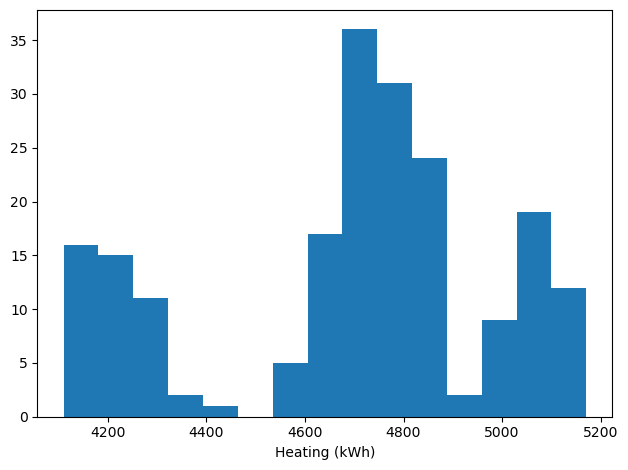

In [287]:
# plot the histogram of the heating energy values
plt.hist(heating_values, bins="sqrt")
plt.xlabel("Heating (kWh)")
plt.tight_layout()

# save the plot
plt.savefig("ua_heating_uncertainty.png", dpi=300)

In [288]:
# Heating - uncertainty statistics
print("Heating uncertainty")

# calculate descriptive statistics
mean = np.mean(heating_values)
std = np.std(heating_values)
skewness = stats.skew(heating_values)

print("  mean:              ", mean)
print("  standard deviation:", std)
print("  skewness:          ", skewness)

# calculate the median
median = np.median(heating_values)

# calculate the 95% percentile interval
# lower bound is the 2.5th percentile (or 0.025 quantile)
# upper bound is 97.5th percentile (or 0.975 quantile)
lb = np.quantile(heating_values, 0.025)
ub = np.quantile(heating_values, 0.975)

print("  median:            ", median)
print("  95% CI lower bound:", lb)
print("  95% CI upper bound:", ub)

Heating uncertainty
  mean:               4692.059502342727
  standard deviation: 292.73117819604647
  skewness:           -0.5282279711284248
  median:             4738.55207361913
  95% CI lower bound: 4145.766293444314
  95% CI upper bound: 5111.175203757023


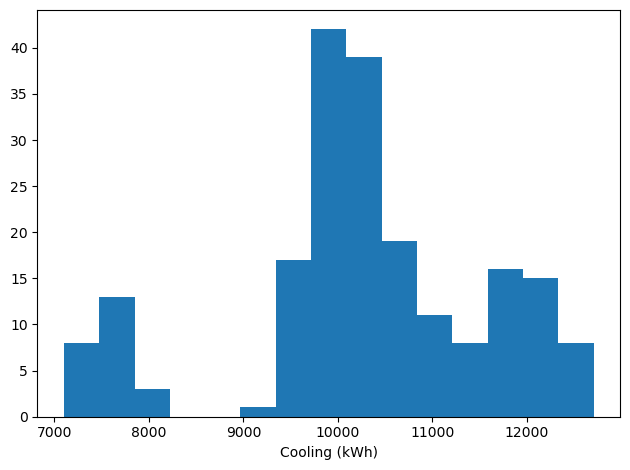

In [289]:
# plot the histogram of the cooling energy values
plt.hist(cooling_values, bins="sqrt")
plt.xlabel("Cooling (kWh)")
plt.tight_layout()

# save the plot
plt.savefig("ua_cooling_uncertainty.png", dpi=300)

In [290]:
# Cooling - uncertainty statistics
print("Cooling uncertainty")

# calculate descriptive statistics
mean = np.mean(cooling_values)
std = np.std(cooling_values)
skewness = stats.skew(cooling_values)

print("  mean:              ", mean)
print("  standard deviation:", std)
print("  skewness:          ", skewness)

# calculate the median
median = np.median(cooling_values)

# calculate the 95% percentile interval
# lower bound is the 2.5th percentile (or 0.025 quantile)
# upper bound is 97.5th percentile (or 0.975 quantile)
lb = np.quantile(cooling_values, 0.025)
ub = np.quantile(cooling_values, 0.975)

print("  median:            ", median)
print("  95% CI lower bound:", lb)
print("  95% CI upper bound:", ub)

Cooling uncertainty
  mean:               10270.333353259599
  standard deviation: 1315.444920644179
  skewness:           -0.45490263263493685
  median:             10167.583299958882
  95% CI lower bound: 7415.193557185608
  95% CI upper bound: 12600.988821158895


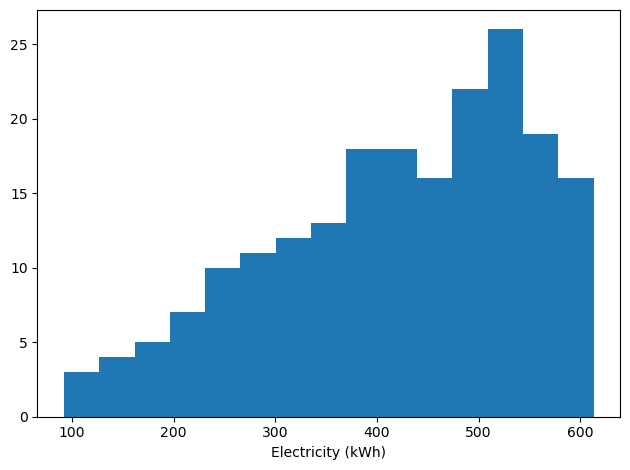

In [291]:
# plot the histogram of the electricity energy values
plt.hist(elec_values, bins="sqrt")
plt.xlabel("Electricity (kWh)")
plt.tight_layout()

# save the plot
plt.savefig("ua_electricity_uncertainty.png", dpi=300)

In [292]:
# Electricity - uncertainty statistics
print("Electricity uncertainty")

# calculate descriptive statistics
mean = np.mean(elec_values)
std = np.std(elec_values)
skewness = stats.skew(elec_values)

print("  mean:              ", mean)
print("  standard deviation:", std)
print("  skewness:          ", skewness)

# calculate the median
median = np.median(elec_values)

# calculate the 95% percentile interval
# lower bound is the 2.5th percentile (or 0.025 quantile)
# upper bound is 97.5th percentile (or 0.975 quantile)
lb = np.quantile(elec_values, 0.025)
ub = np.quantile(elec_values, 0.975)

print("  median:            ", median)
print("  95% CI lower bound:", lb)
print("  95% CI upper bound:", ub)

Electricity uncertainty
  mean:               419.53193899275834
  standard deviation: 126.48234089131753
  skewness:           -0.5534542619062467
  median:             437.5477957628416
  95% CI lower bound: 148.700288153068
  95% CI upper bound: 594.3208078300025


#### <u style="color:orange">Exercise 1 Sensitivity analysis with an EnergyPlus model</u>


In [37]:
import csv
import subprocess
import numpy as np
from pyDOE2 import lhs
from scipy import stats
from pathlib import Path
import matplotlib.pyplot as plt
from eppy.modeleditor import IDF

In [38]:
# Sensitivity analysis
ep_dir = Path("C:\EnergyPlusV9-4-0")

tutorial_dir = Path(".").parent.resolve()

### 1. sampling

In [96]:
n_sample = 200

In [118]:
S_wall_ins_thick = stats.uniform(loc=0.066, scale=0.01).rvs(n_sample)
S_equip_gain = stats.triang(loc=100, scale=140, c=0.6).rvs(n_sample)
S_cooling_sp = stats.uniform(loc=25, scale=4).rvs(n_sample)
S_heating_sp = stats.uniform(loc=18, scale=4).rvs(n_sample)
S_win_height = stats.uniform(loc=1.95, scale=0.1).rvs(n_sample)
S_inf = stats.triang(loc=0.45, scale=0.3, c=0.5).rvs(n_sample)


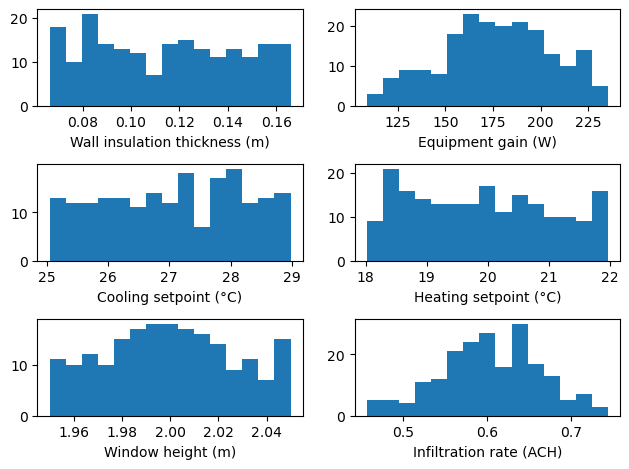

In [119]:
fig, axes = plt.subplots(3, 2)
axes[0, 0].hist(S_wall_ins_thick, bins="sqrt")
axes[0, 0].set_xlabel("Wall insulation thickness (m)")
axes[0, 1].hist(S_equip_gain, bins="sqrt")
axes[0, 1].set_xlabel("Equipment gain (W)")
axes[1, 0].hist(S_cooling_sp, bins="sqrt")
axes[1, 0].set_xlabel("Cooling setpoint (°C)")
axes[1, 1].hist(S_heating_sp, bins="sqrt")
axes[1, 1].set_xlabel("Heating setpoint (°C)")
axes[2, 0].hist(S_win_height, bins="sqrt")
axes[2, 0].set_xlabel("Window height (m)")
axes[2, 1].hist(S_inf, bins="sqrt")
axes[2, 1].set_xlabel("Infiltration rate (ACH)")
fig.tight_layout()

fig.savefig("sa_input_parameters.png", dpi=300)

### 2. evaluation

In [120]:
idd_file = ep_dir / "Energy+.idd"
IDF.setiddname(idd_file)

sa_idf = IDF(tutorial_dir / "Case_600.idf")

In [121]:
sa_dir = tutorial_dir / "sa"
sa_dir.mkdir()

In [122]:
cooling_values = []
heating_values = []
elec_values = []
comf_values = []

ep_exe = ep_dir / "energyplus"
epw_file = tutorial_dir / "BESTEST.epw"

# here, instead of writing three separate loops for
# creating idf files, simulating models, extracting results
# we can achieve them in one loop
for idx, (wall_ins_thick, equip_gain, cooling_sp, heating_sp, win_height, inf) in enumerate(
    zip(S_wall_ins_thick, S_equip_gain, S_cooling_sp, S_heating_sp, S_win_height, S_inf)
):
    # modify the thickness field for the wall insulation
    wall_ins_obj = sa_idf.getobject("Material", "Fiberglass quilt-Wall")
    sa_idf.idfobjects["Material"][1].Thickness = wall_ins_thick

    # modify the equipment level field
    equip_obj = sa_idf.idfobjects["ElectricEquipment"][0]
    equip_obj.Design_Level = equip_gain

    # modify the cooling setpoint field
    thermostat_obj = sa_idf.idfobjects["HVACTemplate:Thermostat"][0]
    thermostat_obj.Constant_Cooling_Setpoint = cooling_sp
    
    # modify the heating setpoint field
    thermostat_obj = sa_idf.idfobjects["HVACTemplate:Thermostat"][0]
    thermostat_obj.Constant_Heating_Setpoint = heating_sp

    # modify the top window Z vertices as per the new window height
    win_left_obj = sa_idf.getobject("FenestrationSurface:Detailed", "Left Window")
    win_right_obj = sa_idf.getobject("FenestrationSurface:Detailed", "Right Window")
    bottom_height = win_left_obj.Vertex_2_Zcoordinate
    win_left_obj.Vertex_1_Zcoordinate = bottom_height + win_height
    win_left_obj.Vertex_4_Zcoordinate = bottom_height + win_height
    win_right_obj.Vertex_1_Zcoordinate = bottom_height + win_height
    win_right_obj.Vertex_4_Zcoordinate = bottom_height + win_height
    
    # modify the infiltration rate field
    equip_obj = sa_idf.idfobjects["ZoneInfiltration:DesignFlowRate"][0]
    equip_obj.Air_Changes_per_Hour = inf   
    
    # create each job idf file
    job_dir = sa_dir / f"job_{idx:03}"
    job_dir.mkdir()
    job_idf_file = job_dir / "in.idf"
    sa_idf.saveas(job_idf_file)

    # run each job simulation
    job_idf_file = job_dir / "in.idf"
    commands = [ep_exe, "-x", "-r", "-w", epw_file, job_idf_file]
    subprocess.run(commands, cwd=job_dir, capture_output=True)
    if idx % 10 == 9:
        print(f"job_{idx:03} finished.")

    # extract each job results
    job_output_file = job_dir / "eplusout.csv"

    with open(job_output_file, "rt") as fp:
        job_output_reader = csv.reader(fp)
        job_output = list(job_output_reader)
        comf_value = float(job_output[1][1])
        heating_value = float(job_output[1][3]) / 3600000
        cooling_value = float(job_output[1][4]) / 3600000
        elec_value = float(job_output[1][5]) / 3600000

    cooling_values.append(cooling_value)
    heating_values.append(heating_value)
    elec_values.append(elec_value)
    comf_values.append(comf_value)

job_009 finished.
job_019 finished.
job_029 finished.
job_039 finished.
job_049 finished.
job_059 finished.
job_069 finished.
job_079 finished.
job_089 finished.
job_099 finished.
job_109 finished.
job_119 finished.
job_129 finished.
job_139 finished.
job_149 finished.
job_159 finished.
job_169 finished.
job_179 finished.
job_189 finished.
job_199 finished.


### 3. analysis

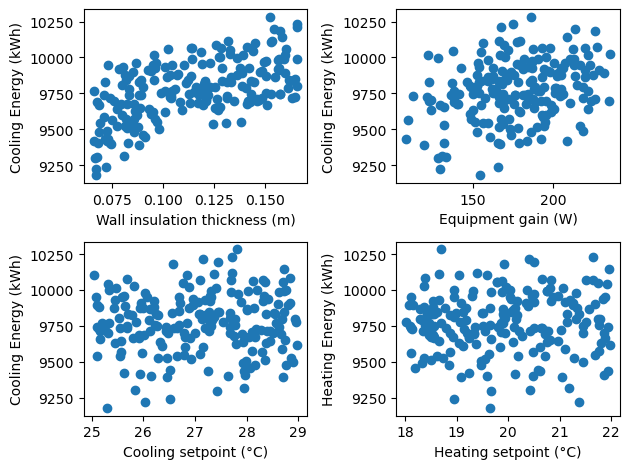

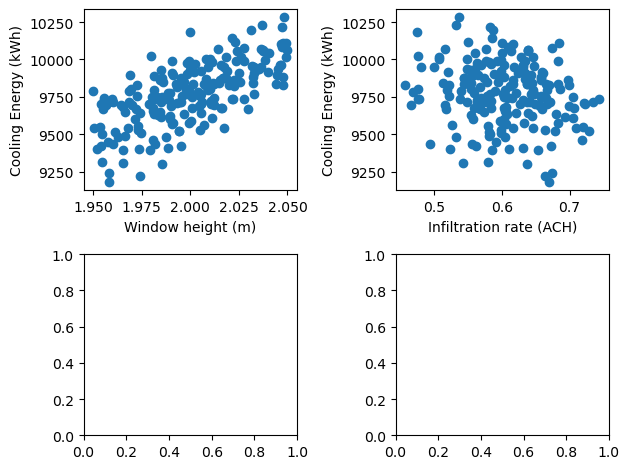

In [123]:
# Cooling - Scatter plot
fig, axes = plt.subplots(2, 2)
axes[0, 0].scatter(S_wall_ins_thick, cooling_values)
axes[0, 0].set_xlabel("Wall insulation thickness (m)")
axes[0, 0].set_ylabel("Cooling Energy (kWh)")
axes[0, 1].scatter(S_equip_gain, cooling_values)
axes[0, 1].set_xlabel("Equipment gain (W)")
axes[0, 1].set_ylabel("Cooling Energy (kWh)")
axes[1, 0].scatter(S_cooling_sp, cooling_values)
axes[1, 0].set_xlabel("Cooling setpoint (°C)")
axes[1, 0].set_ylabel("Cooling Energy (kWh)")
axes[1, 1].scatter(S_heating_sp, cooling_values)
axes[1, 1].set_xlabel("Heating setpoint (°C)")
axes[1, 1].set_ylabel("Heating Energy (kWh)")
fig.tight_layout()
fig.savefig("sa_cooling_scatter1.png", dpi=300)

fig, axes = plt.subplots(2, 2)
axes[0, 0].scatter(S_win_height, cooling_values)
axes[0, 0].set_xlabel("Window height (m)")
axes[0, 0].set_ylabel("Cooling Energy (kWh)")
axes[0, 1].scatter(S_inf, cooling_values)
axes[0, 1].set_xlabel("Infiltration rate (ACH)")
axes[0, 1].set_ylabel("Cooling Energy (kWh)")
fig.tight_layout()
fig.savefig("sa_cooling_scatter2.png", dpi=300)

In [124]:
# Cooling - Peason's r
cooling_r_wall_ins_thick = np.corrcoef(S_wall_ins_thick, cooling_values)[0, 1]
cooling_r_equip_gain = np.corrcoef(S_equip_gain, cooling_values)[0, 1]
cooling_r_cooling_sp = np.corrcoef(S_cooling_sp, cooling_values)[0, 1]
cooling_r_heating_sp = np.corrcoef(S_heating_sp, cooling_values)[0, 1]
cooling_r_win_height = np.corrcoef(S_win_height, cooling_values)[0, 1]
cooling_r_inf = np.corrcoef(S_inf, cooling_values)[0, 1]

print("Cooling - Peason's r")
print("    Wall insulation thickness:", cooling_r_wall_ins_thick)
print("    equip gain:              ", cooling_r_equip_gain)
print("    Cooling setpoint:         ", cooling_r_cooling_sp)
print("    Heating setpoint:         ", cooling_r_heating_sp)
print("    Window height:             ", cooling_r_win_height)
print("    Infiltration rate:         ", cooling_r_inf)

Cooling - Peason's r
    Wall insulation thickness: 0.5804079598598973
    equip gain:               0.2931678160685175
    Cooling setpoint:          0.048311837319952686
    Heating setpoint:          0.039130080571615156
    Window height:              0.6802382235966373
    Infiltration rate:          -0.18094683371571008


In [125]:
# Cooling - Spearman's ρ
cooling_rho_wall_ins_thick = stats.spearmanr(S_wall_ins_thick, cooling_values)[0]
cooling_rho_equip_gain = stats.spearmanr(S_equip_gain, cooling_values)[0]
cooling_rho_cooling_sp = stats.spearmanr(S_cooling_sp, cooling_values)[0]
cooling_rho_heating_sp = stats.spearmanr(S_heating_sp, cooling_values)[0]
cooling_rho_win_height = stats.spearmanr(S_win_height, cooling_values)[0]
cooling_rho_inf = stats.spearmanr(S_inf, cooling_values)[0]

print("Cooling - Spearman's ρ")
print("    Wall insulation thickness:", cooling_rho_wall_ins_thick)
print("    equip gain:              ", cooling_rho_equip_gain)
print("    Cooling setpoint:         ", cooling_rho_cooling_sp)
print("    Heating setpoint:         ", cooling_rho_heating_sp)
print("    Window height:             ", cooling_rho_win_height)
print("    Infiltration rate:         ", cooling_rho_inf)

Cooling - Spearman's ρ
    Wall insulation thickness: 0.5463241581039526
    equip gain:               0.2640891022275557
    Cooling setpoint:          0.030711767794194857
    Heating setpoint:          0.056155403885097134
    Window height:              0.6853896347408687
    Infiltration rate:          -0.1689132228305708


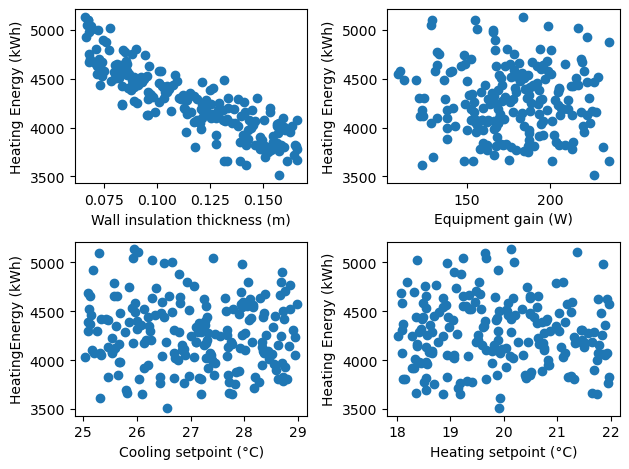

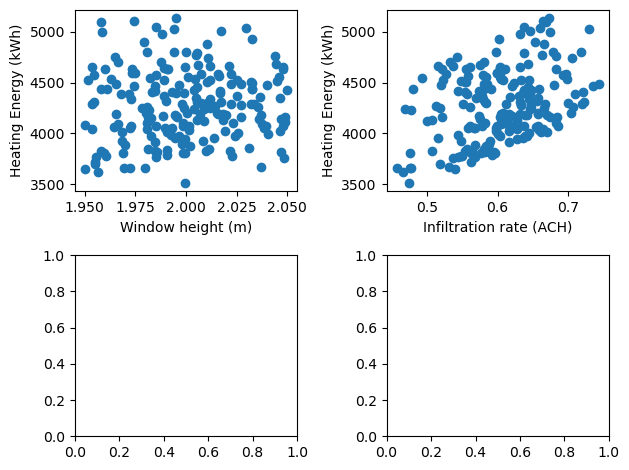

In [126]:
# Heating - Scatter plot
fig, axes = plt.subplots(2, 2)
axes[0, 0].scatter(S_wall_ins_thick, heating_values)
axes[0, 0].set_xlabel("Wall insulation thickness (m)")
axes[0, 0].set_ylabel("Heating Energy (kWh)")
axes[0, 1].scatter(S_equip_gain, heating_values)
axes[0, 1].set_xlabel("Equipment gain (W)")
axes[0, 1].set_ylabel("Heating Energy (kWh)")
axes[1, 0].scatter(S_cooling_sp, heating_values)
axes[1, 0].set_xlabel("Cooling setpoint (°C)")
axes[1, 0].set_ylabel("HeatingEnergy (kWh)")
axes[1, 1].scatter(S_heating_sp, heating_values)
axes[1, 1].set_xlabel("Heating setpoint (°C)")
axes[1, 1].set_ylabel("Heating Energy (kWh)")
fig.tight_layout()
fig.savefig("sa_Heating_scatter1.png", dpi=300)

fig, axes = plt.subplots(2, 2)
axes[0, 0].scatter(S_win_height, heating_values)
axes[0, 0].set_xlabel("Window height (m)")
axes[0, 0].set_ylabel("Heating Energy (kWh)")
axes[0, 1].scatter(S_inf, heating_values)
axes[0, 1].set_xlabel("Infiltration rate (ACH)")
axes[0, 1].set_ylabel("Heating Energy (kWh)")
fig.tight_layout()
fig.savefig("sa_Heating_scatter2.png", dpi=300)

In [127]:
# Heating - Peason's r
heating_r_wall_ins_thick = np.corrcoef(S_wall_ins_thick, heating_values)[0, 1]
heating_r_equip_gain = np.corrcoef(S_equip_gain, heating_values)[0, 1]
heating_r_cooling_sp = np.corrcoef(S_cooling_sp, heating_values)[0, 1]
heating_r_heating_sp = np.corrcoef(S_heating_sp, heating_values)[0, 1]
heating_r_win_height = np.corrcoef(S_win_height, heating_values)[0, 1]
heating_r_inf = np.corrcoef(S_inf, heating_values)[0, 1]

print("Heating - Peason's r")
print("    Wall insulation thickness:", heating_r_wall_ins_thick)
print("    equip gain:              ", heating_r_equip_gain)
print("    Cooling setpoint:         ", heating_r_cooling_sp)
print("    Heating setpoint:         ", heating_r_heating_sp)
print("    Window height:             ", heating_r_win_height)
print("    Infiltration rate:         ", heating_r_inf)

Heating - Peason's r
    Wall insulation thickness: -0.8666322461319558
    equip gain:               -0.03406595204186875
    Cooling setpoint:          -0.07729771863402177
    Heating setpoint:          -0.03434104125795105
    Window height:              0.06669784806561911
    Infiltration rate:          0.37458569903000893


In [128]:
# Heating - Spearman's ρ
heating_rho_wall_ins_thick = stats.spearmanr(S_wall_ins_thick, heating_values)[0]
heating_rho_equip_gain = stats.spearmanr(S_equip_gain, heating_values)[0]
heating_rho_cooling_sp = stats.spearmanr(S_cooling_sp, heating_values)[0]
heating_rho_heating_sp = stats.spearmanr(S_heating_sp, heating_values)[0]
heating_rho_win_height = stats.spearmanr(S_win_height, heating_values)[0]
heating_rho_inf = stats.spearmanr(S_inf, heating_values)[0]

print("Heating - Spearman's ρ")
print("    Wall insulation thickness:", heating_rho_wall_ins_thick)
print("    equip gain:              ", heating_rho_equip_gain)
print("    Cooling setpoint:         ", heating_rho_cooling_sp)
print("    Heating setpoint:         ", heating_rho_heating_sp)
print("    Window height:             ", heating_rho_win_height)
print("    Infiltration rate:         ", heating_rho_inf)

Heating - Spearman's ρ
    Wall insulation thickness: -0.8855696392409811
    equip gain:               -0.007179179479486987
    Cooling setpoint:          -0.06612315307882698
    Heating setpoint:          -0.03256581414535364
    Window height:              0.07946598664966625
    Infiltration rate:          0.3223220580514513


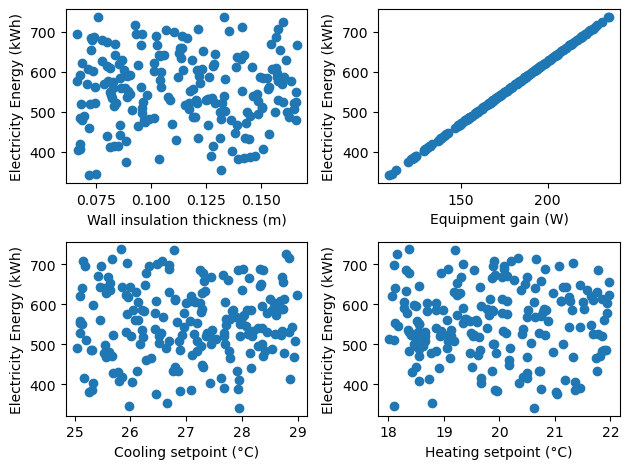

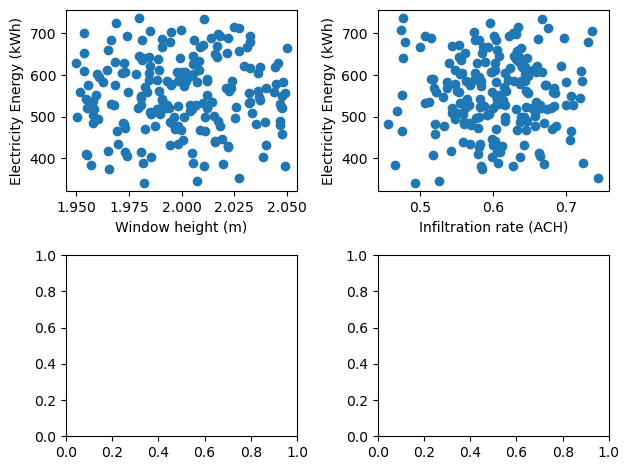

In [129]:
# Electricity - Scatter plot
fig, axes = plt.subplots(2, 2)
axes[0, 0].scatter(S_wall_ins_thick, elec_values)
axes[0, 0].set_xlabel("Wall insulation thickness (m)")
axes[0, 0].set_ylabel("Electricity Energy (kWh)")
axes[0, 1].scatter(S_equip_gain, elec_values)
axes[0, 1].set_xlabel("Equipment gain (W)")
axes[0, 1].set_ylabel("Electricity Energy (kWh)")
axes[1, 0].scatter(S_cooling_sp, elec_values)
axes[1, 0].set_xlabel("Cooling setpoint (°C)")
axes[1, 0].set_ylabel("Electricity Energy (kWh)")
axes[1, 1].scatter(S_heating_sp, elec_values)
axes[1, 1].set_xlabel("Heating setpoint (°C)")
axes[1, 1].set_ylabel("Electricity Energy (kWh)")
fig.tight_layout()
fig.savefig("sa_Electricity_scatter1.png", dpi=300)

fig, axes = plt.subplots(2, 2)
axes[0, 0].scatter(S_win_height, elec_values)
axes[0, 0].set_xlabel("Window height (m)")
axes[0, 0].set_ylabel("Electricity Energy (kWh)")
axes[0, 1].scatter(S_inf, elec_values)
axes[0, 1].set_xlabel("Infiltration rate (ACH)")
axes[0, 1].set_ylabel("Electricity Energy (kWh)")
fig.tight_layout()
fig.savefig("sa_Electricity_scatter2.png", dpi=300)

In [130]:
# Electricity - Peason's r
elec_r_wall_ins_thick = np.corrcoef(S_wall_ins_thick, elec_values)[0, 1]
elec_r_equip_gain = np.corrcoef(S_equip_gain, elec_values)[0, 1]
elec_r_cooling_sp = np.corrcoef(S_cooling_sp, elec_values)[0, 1]
elec_r_heating_sp = np.corrcoef(S_heating_sp, elec_values)[0, 1]
elec_r_win_height = np.corrcoef(S_win_height, elec_values)[0, 1]
elec_r_inf = np.corrcoef(S_inf, elec_values)[0, 1]

print("Electricity - Peason's r")
print("    Wall insulation thickness:", elec_r_wall_ins_thick)
print("    equip gain:              ", elec_r_equip_gain)
print("    Cooling setpoint:         ", elec_r_cooling_sp)
print("    Heating setpoint:         ", elec_r_heating_sp)
print("    Window height:             ", elec_r_win_height)
print("    Infiltration rate:         ", elec_r_inf)

Electricity - Peason's r
    Wall insulation thickness: -0.022141440667558212
    equip gain:               1.0
    Cooling setpoint:          0.034618691182237996
    Heating setpoint:          0.005207579658976207
    Window height:              0.021182047169416008
    Infiltration rate:          0.0026117789003240197


In [131]:
# Electricity - Spearman's ρ
elec_rho_wall_ins_thick = stats.spearmanr(S_wall_ins_thick, elec_values)[0]
elec_rho_equip_gain = stats.spearmanr(S_equip_gain, elec_values)[0]
elec_rho_cooling_sp = stats.spearmanr(S_cooling_sp, elec_values)[0]
elec_rho_heating_sp = stats.spearmanr(S_heating_sp, elec_values)[0]
elec_rho_win_height = stats.spearmanr(S_win_height, elec_values)[0]
elec_rho_inf = stats.spearmanr(S_inf, elec_values)[0]

print("Electricity - Spearman's ρ")
print("    Wall insulation thickness:", elec_rho_wall_ins_thick)
print("    equip gain:              ", elec_rho_equip_gain)
print("    Cooling setpoint:         ", elec_rho_cooling_sp)
print("    Heating setpoint:         ", elec_rho_heating_sp)
print("    Window height:             ", elec_rho_win_height)
print("    Infiltration rate:         ", elec_rho_inf)

Electricity - Spearman's ρ
    Wall insulation thickness: -0.034832370809270236
    equip gain:               1.0
    Cooling setpoint:          0.03388584714617866
    Heating setpoint:          0.02907972699317483
    Window height:              0.02071101777544439
    Infiltration rate:          0.005659641491037277


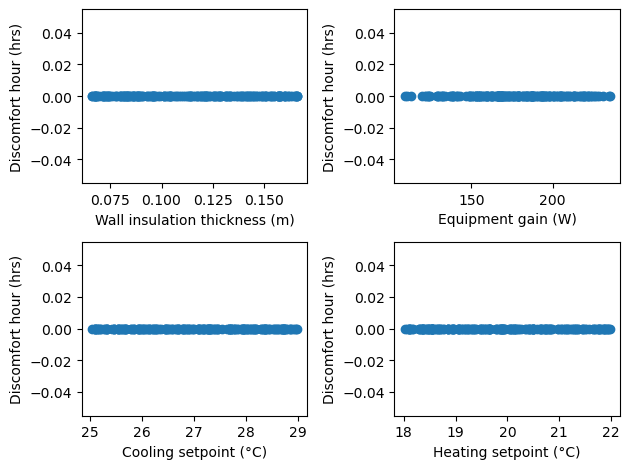

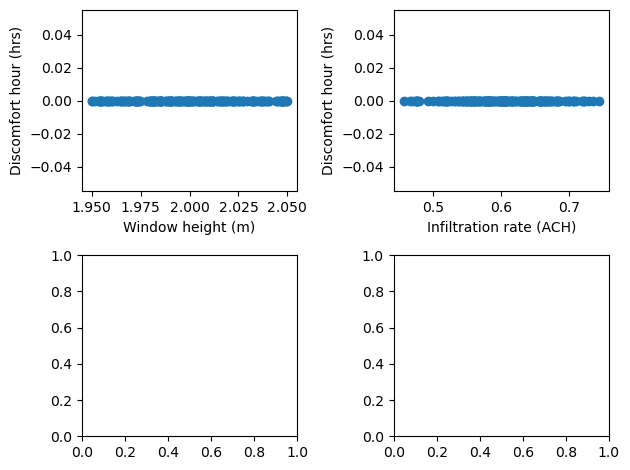

In [132]:
# Comfort - Scatter plot
fig, axes = plt.subplots(2, 2)
axes[0, 0].scatter(S_wall_ins_thick, comf_values)
axes[0, 0].set_xlabel("Wall insulation thickness (m)")
axes[0, 0].set_ylabel("Discomfort hour (hrs)")
axes[0, 1].scatter(S_equip_gain, comf_values)
axes[0, 1].set_xlabel("Equipment gain (W)")
axes[0, 1].set_ylabel("Discomfort hour (hrs)")
axes[1, 0].scatter(S_cooling_sp, comf_values)
axes[1, 0].set_xlabel("Cooling setpoint (°C)")
axes[1, 0].set_ylabel("Discomfort hour (hrs)")
axes[1, 1].scatter(S_heating_sp, comf_values)
axes[1, 1].set_xlabel("Heating setpoint (°C)")
axes[1, 1].set_ylabel("Discomfort hour (hrs)")
fig.tight_layout()
fig.savefig("sa_Comfort_scatter1.png", dpi=300)

fig, axes = plt.subplots(2, 2)
axes[0, 0].scatter(S_win_height, comf_values)
axes[0, 0].set_xlabel("Window height (m)")
axes[0, 0].set_ylabel("Discomfort hour (hrs)")
axes[0, 1].scatter(S_inf, comf_values)
axes[0, 1].set_xlabel("Infiltration rate (ACH)")
axes[0, 1].set_ylabel("Discomfort hour (hrs)")
fig.tight_layout()
fig.savefig("sa_Comfort_scatter2.png", dpi=300)

In [133]:
# Comfort - Peason's r
comf_r_wall_ins_thick = np.corrcoef(S_wall_ins_thick, comf_values)[0, 1]
comf_r_equip_gain = np.corrcoef(S_equip_gain, comf_values)[0, 1]
comf_r_cooling_sp = np.corrcoef(S_cooling_sp, comf_values)[0, 1]
comf_r_heating_sp = np.corrcoef(S_heating_sp, comf_values)[0, 1]
comf_r_win_height = np.corrcoef(S_win_height, comf_values)[0, 1]
comf_r_inf = np.corrcoef(S_inf, comf_values)[0, 1]

print("Comfort - Peason's r")
print("    Wall insulation thickness:", comf_r_wall_ins_thick)
print("    equip gain:              ", comf_r_equip_gain)
print("    Cooling setpoint:         ", comf_r_cooling_sp)
print("    Heating setpoint:         ", comf_r_heating_sp)
print("    Window height:             ", comf_r_win_height)
print("    Infiltration rate:         ", comf_r_inf)

Comfort - Peason's r
    Wall insulation thickness: nan
    equip gain:               nan
    Cooling setpoint:          nan
    Heating setpoint:          nan
    Window height:              nan
    Infiltration rate:          nan


In [134]:
# Comfort - Spearman's ρ
comf_rho_wall_ins_thick = stats.spearmanr(S_wall_ins_thick, comf_values)[0]
comf_rho_equip_gain = stats.spearmanr(S_equip_gain, comf_values)[0]
comf_rho_cooling_sp = stats.spearmanr(S_cooling_sp, comf_values)[0]
comf_rho_heating_sp = stats.spearmanr(S_heating_sp, comf_values)[0]
comf_rho_win_height = stats.spearmanr(S_win_height, comf_values)[0]
comf_rho_inf = stats.spearmanr(S_inf, comf_values)[0]

print("Comfort - Spearman's ρ")
print("    Wall insulation thickness:", comf_rho_wall_ins_thick)
print("    equip gain:              ", comf_rho_equip_gain)
print("    Cooling setpoint:         ", comf_rho_cooling_sp)
print("    Heating setpoint:         ", comf_rho_heating_sp)
print("    Window height:             ", comf_rho_win_height)
print("    Infiltration rate:         ", comf_rho_inf)

Comfort - Spearman's ρ
    Wall insulation thickness: nan
    equip gain:               nan
    Cooling setpoint:          nan
    Heating setpoint:          nan
    Window height:              nan
    Infiltration rate:          nan
